# DNN: the Basics

In this notebook, we will learn the basics of a Deep Neural Network (DNN) based on [Keras](https://keras.io/), a high-level API for building and training deep learning models, running on top of [TensorFlow](https://www.tensorflow.org/), an open source platform for machine learning. 

We will use the `fashion-mnist` dataset, which is useful for quick examples when learning the basics. In [03_DNN_practical.ipynb](03_DNN_practical.ipynb), we will follow the same principles to practice with a more relevant scientific dataset. To understand how a DNN works, we will implement a fully connected DNN from scratch in [04_DNN_backprop.ipynb](04_DNN_backprop.ipynb), 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow v2.3.1


---

# The dataset

To start with, we load the `fashion-mnist` dataset from Keras:

In [2]:
# load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

# string labels
string_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0].shape))
print("Number of classes: %d" % (np.max(train_labels) + 1))

Number of training data: 60000
Number of test data: 10000
Image pixels: (28, 28)
Number of classes: 10


We can randomly plot some images and their labels:

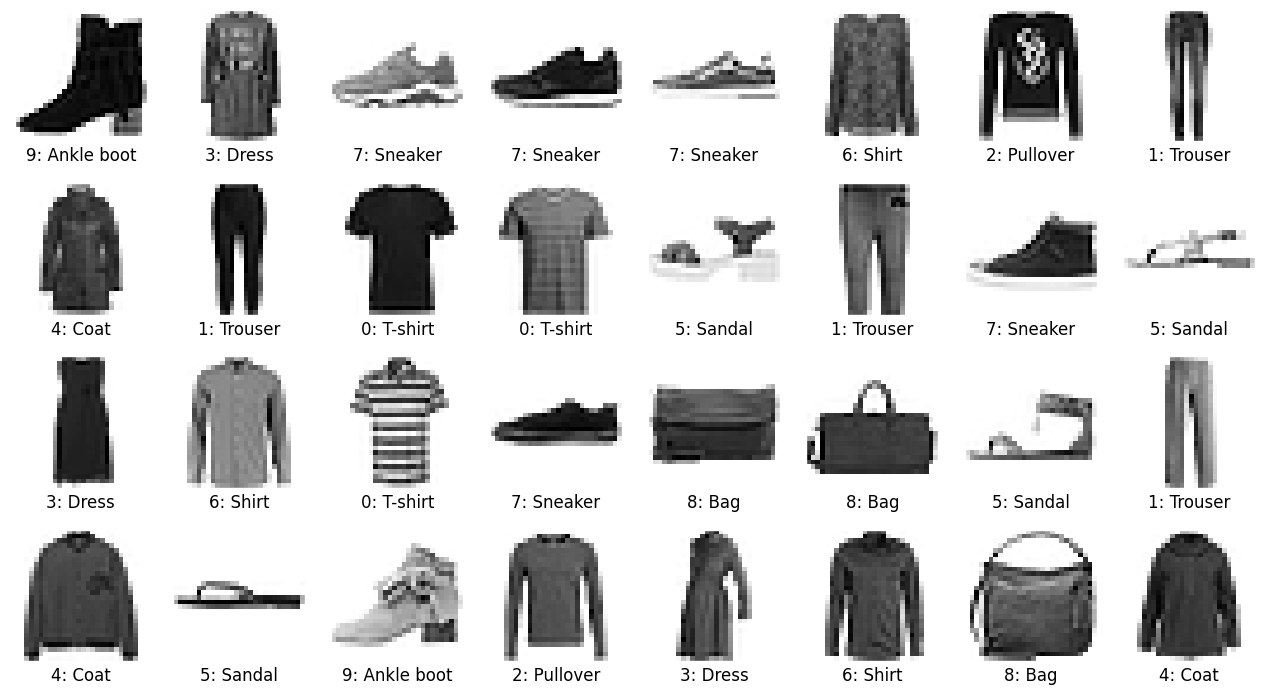

In [3]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

---

# Classification by DNN

Here we will create and train a DNN model to classify the images in `fashion-mnist`. With Keras, the task can be divided into three essential steps:

1. Build the network architecture;
2. Compile the model;
3. Train the model.

These steps may be repeated for a few times to improve the quality (accuracy and stability) of the model.

## 1. Build the network architecture

Our first DNN will be a simple multi-layer perceptron with only one hidden layer, as shown in the following figure:


![dense.jpeg](https://i.ibb.co/0yrVL28/dnn.png)



In general, a network of this kind should include an input layer, some hidden layers and an output layer. In this example, all the layers will be `Dense` layers.


### The input layer

We first need to determine the dimensionality of the input layer. In this case, we flatten (using a `Flatten` layer) the images and feed them to the network. As the images are 28 $\times$ 28 in pixels, the input size will be 784.


### The hidden layers

We use one hidden layer in this case and use `ReLU` as its activation function:

> $R(x)=\max(0,x)$

**NOTE**: Different activation functions are used for different tasks. Remember that `ReLU` generally performs well for training a network, but it can *only* be used in the hidden layers.


### The output layer

We usually encode categorical data as a "one-hot" vector. In this case, we have a vector of length 10 on the output side, where each element corresponds to a class of apparel. Ideally, we hope the values to be either 1 or 0, with 1 for the correct class and 0 for the others, so we use `sigmoid` as the activation function for the output layer:

> $S(x) = \dfrac{1}{1 + e^{-x}}$

In [4]:
# build the network architecture
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

We can take a look at the summary of the model using `model.summary()`. The number of trainable parameters of a layer = $P\times N+N$, where $P$ is the size of its precedent layer and $N$ its own size. Here $P\times N$ accounts for the weights of the $P\times N$ connections and $N$ for the biases of this layer.

In [5]:
# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## 2. Compile the model

Next, we need to compile our model. This is where we specify all sorts of hyperparameters associated with the model. Here are the most important ones:

### Loss

The loss is the objective function to be minimised during training. Gradients of the loss with respect to the model parameters, calculated by backpropagating the errors, determine the direction to update the model parameters. Follow [04_DNN_backprop.ipynb](04_DNN_backprop.ipynb) to learn the details about *backpropagation* and *gradient descent*. In this case, we will use `SparseCategoricalCrossentropy` as the loss. The term *sparse* means that the output vector is sparse, with many more zeros than ones in the one-hot encoding.


### Optimiser

An optimiser is an algorithm determining how the model parameters are updated based on the loss. One critical hyperparameter for the optimiser is the *learning rate*, which determines the magnitude to update the model parameters (also see [04_DNN_backprop.ipynb](04_DNN_backprop.ipynb) for details). In many applications, *Adam* is usually a good choice at the beginning. We will use Adam in this example.


### Metric

The metrics do not affect the training result but monitor the training process to give us a sense of how well the model is improving after seeing more data. We can also use them to choose between models at the end. In our case, we will monitor the `accuracy`.

In [6]:
# compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## 3. Train the model

Now we can start to train the model with `fashion-mnist`. This is done by calling the `model.fit()` method, where we need to specify a few more parameters:

### Epochs

It is the number of times that the model will run through the entire dataset during training.


### Batch size

It determines how many data will be used at a time to determine the gradient used for parameter update. Follow [04_DNN_backprop.ipynb](04_DNN_backprop.ipynb) to learn more about *Batch*, *Mini-batch* and *Stochastic Gradient Descent*.


### Validation data
Accuracy and loss can be computed and logged with a validation dataset passed to `model.fit()`. To make predictions with a confidence equivalent to that for training, the accuracy for the validation data should not differ too much from that for the training data.

In [7]:
# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32, 
                             validation_data=(test_images, test_labels))

Epoch 1/50
1875/1875 [==============================] - 2s 942us/step - loss: 0.5210 - accuracy: 0.8196 - val_loss: 0.4281 - val_accuracy: 0.8512
Epoch 2/50
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3919 - accuracy: 0.8599 - val_loss: 0.3839 - val_accuracy: 0.8654
Epoch 3/50
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3487 - accuracy: 0.8730 - val_loss: 0.4110 - val_accuracy: 0.8513
Epoch 4/50
1875/1875 [==============================] - 2s 879us/step - loss: 0.3247 - accuracy: 0.8817 - val_loss: 0.3735 - val_accuracy: 0.8651
Epoch 5/50
1875/1875 [==============================] - 2s 928us/step - loss: 0.3056 - accuracy: 0.8885 - val_loss: 0.3616 - val_accuracy: 0.8712
Epoch 6/50
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2894 - accuracy: 0.8942 - val_loss: 0.3796 - val_accuracy: 0.8636
Epoch 7/50
1875/1875 [==============================] - 2s 984us/step - loss: 0.2780 - accuracy: 0.8965 - val_loss: 0.3568 - val_a

### Check training history

We can examine the training history by plotting accuracy and loss against epoch for both the training and the test data. 

Notice that the accuracies for the training and the test data diverge as the model trains. This is a classic symptom of [overfitting](https://en.wikipedia.org/wiki/Overfitting), that is, our model corresponds too closely to the training data so that it cannot fit the test data with an equivalent accuracy.

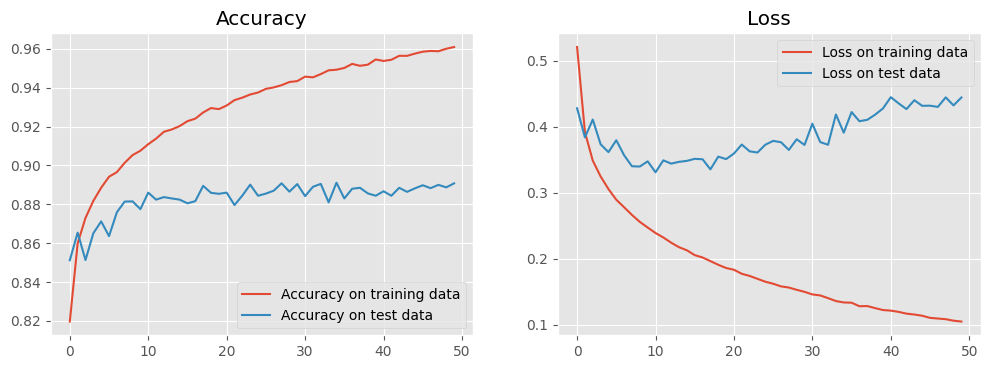

In [8]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

## 4. Rgularise and re-train

Dropout, also called dilution, is a regularisation technique to mitigate against overfitting by randomly omitting a certain amount of neurons from a layer. Here we will rebuild our model with `Dropout` between the hidden and the output layers. Let us see whether this can negate the overfitting or not.

In [9]:
# build the network architecture
model_reg = Sequential()
model_reg.add(Flatten(input_shape=(28, 28)))
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dropout(0.4))
model_reg.add(Dense(10, activation='sigmoid'))

# compile the model
model_reg.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

In [10]:
# train the model
training_history_reg = model_reg.fit(train_images, train_labels, epochs=50, batch_size=32, 
                                     validation_data=(test_images, test_labels))

Epoch 1/50
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6269 - accuracy: 0.7821 - val_loss: 0.4553 - val_accuracy: 0.8333
Epoch 2/50
1875/1875 [==============================] - 1s 788us/step - loss: 0.4514 - accuracy: 0.8373 - val_loss: 0.4037 - val_accuracy: 0.8522
Epoch 3/50
1875/1875 [==============================] - 2s 826us/step - loss: 0.4164 - accuracy: 0.8498 - val_loss: 0.3904 - val_accuracy: 0.8592
Epoch 4/50
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3955 - accuracy: 0.8580 - val_loss: 0.3823 - val_accuracy: 0.8588
Epoch 5/50
1875/1875 [==============================] - 2s 942us/step - loss: 0.3792 - accuracy: 0.8637 - val_loss: 0.3829 - val_accuracy: 0.8604
Epoch 6/50
1875/1875 [==============================] - 2s 811us/step - loss: 0.3671 - accuracy: 0.8658 - val_loss: 0.3716 - val_accuracy: 0.8685
Epoch 7/50
1875/1875 [==============================] - 2s 859us/step - loss: 0.3585 - accuracy: 0.8690 - val_loss: 0.3672 - val

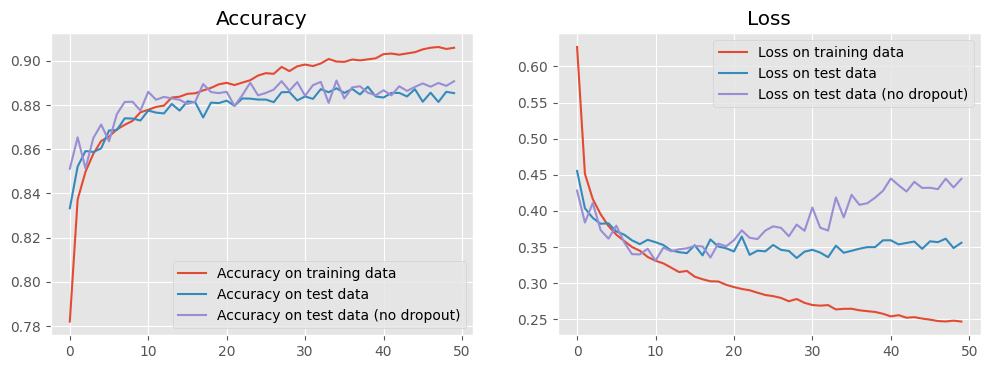

In [11]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history_reg.history[acc_str], label='Accuracy on training data')
plt.plot(training_history_reg.history['val_' + acc_str], label='Accuracy on test data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data (no dropout)')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history_reg.history['loss'], label='Loss on training data')
plt.plot(training_history_reg.history['val_loss'], label='Loss on test data')
plt.plot(training_history.history['val_loss'], label='Loss on test data (no dropout)')
plt.legend()
plt.title("Loss")
plt.show()

## 5. Make predictions

Finally, we can use our trained model to make predictions. Here we show some wrong predictions for the test data, from which we may get some ideas about what kinds of images baffle our model.

In [12]:
# use test images to make predictions
pred_lables = model_reg.predict(test_images).argmax(axis=1)

Number of test data: 10000
Number of wrong predictions: 1146


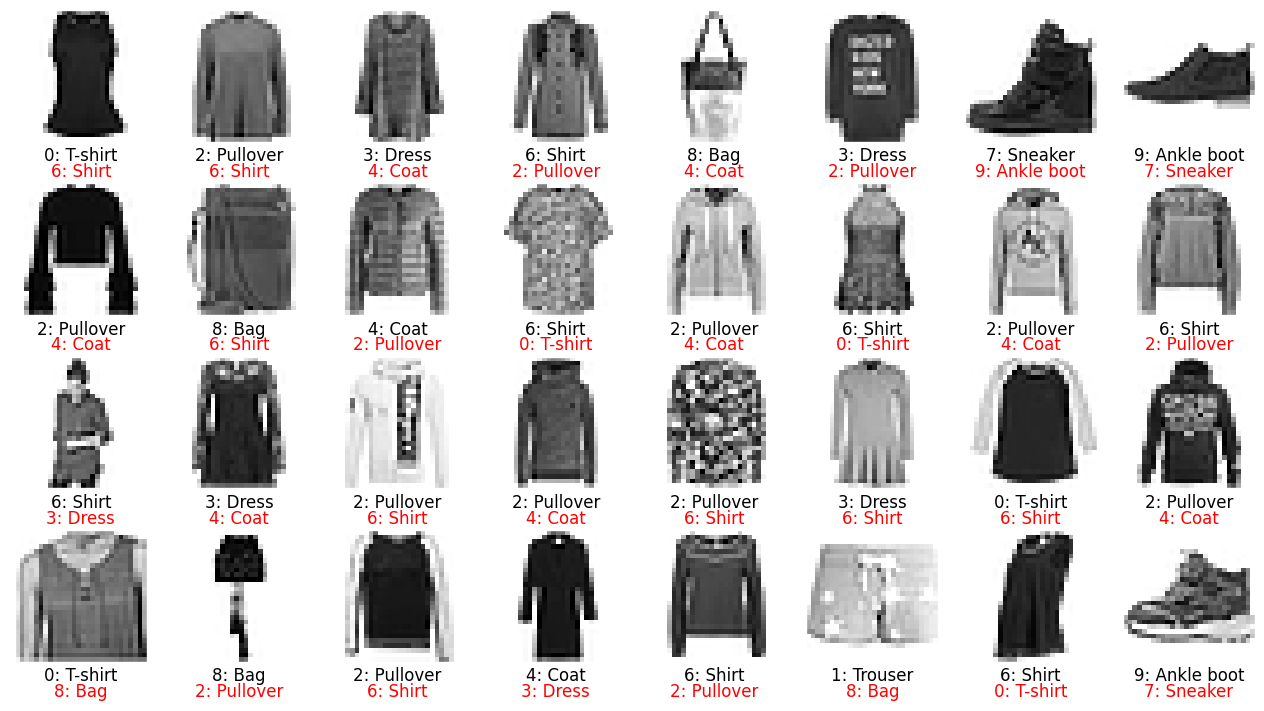

In [13]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(test_images[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

## Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)); 
* Use two hidden layers (with dropout), e.g., respectively with sizes 256 and 64, and see whether the accuracy can be improved or not;
* Change the output from 0-1 binary to probability, i.e., the one-hot vector represents the probabilities that an image belongs to the classes; this can be achieved by 1) removing `activation='sigmoid'` from the output layer and 2) appending a `Softmax` layer after the trained model, e.g.,
```python
probability_model = Sequential([model_reg, keras.layers.Softmax()])
```